In [ ]:
#| hide
from hybridpredictmaize22.GEMdataset import *
from hybridpredictmaize22.GEMlearn import *

%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

# hybridpredictmaize22

> GxExM yield prediction

Repo for analysis of GEM prediction for maize yield

## How to use

A demo of the library specifically for this dataset

In [ ]:
Yield, Genotype, Weather = prep_gem_data(trait_csv='./data/Training_Data/1_Training_Trait_Data_2014_2021.csv',
                weather_csv = './data/Training_Data/4_Training_Weather_Data_2014_2021.csv',
                snp_folder = './data/snpCompress/PCS_10/'
               )

136012 plots with 26 features
77431 daily weather measurements with 18 features
4928 hybrids


In [ ]:
Yield

,index,Env,Year,Field_Location,Experiment,Replicate,Block,Plot,Range,Pass,...,Stand_Count_plants,Pollen_DAP_days,Silk_DAP_days,Plant_Height_cm,Ear_Height_cm,Root_Lodging_plants,Stalk_Lodging_plants,Yield_Mg_ha,Grain_Moisture,Twt_kg_m3
0,0,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,1,1.0,1.0,...,56.0,63.0,67.0,213.00,79.00,0.0,0.0,5.721725,20.8,706.664693
1,1,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,2,1.0,2.0,...,54.0,61.0,63.0,286.00,172.00,0.0,0.0,11.338246,25.8,693.792841
2,2,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,3,1.0,3.0,...,60.0,63.0,65.0,239.00,92.00,0.0,4.0,6.540810,20.8,698.941582
3,3,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,4,1.0,4.0,...,59.0,61.0,63.0,242.00,118.00,0.0,0.0,10.366857,23.7,711.813434
4,4,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,5,1.0,5.0,...,58.0,63.0,65.0,211.00,92.00,0.0,0.0,10.908814,19.4,743.993065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129303,136007,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,496,19.0,9.0,...,80.0,75.0,76.0,251.67,123.33,NaN,NaN,9.972527,16.9,698.941582
129304,136008,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,497,19.0,8.0,...,65.0,81.0,90.0,303.33,148.33,1.0,NaN,9.160941,23.7,709.239064
129305,136009,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,498,19.0,7.0,...,69.0,76.0,79.0,301.67,150.00,NaN,NaN,9.256348,19.5,732.408398
129306,136010,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,499,19.0,6.0,...,81.0,78.0,79.0,293.33,165.00,1.0,5.0,11.504058,19.1,692.505656


In [ ]:
Genotype

(array(['2369/DK3IIH6', '2369/PHN82', '2369/PHZ51', ...,
        'Z038E0057/DK3IIH6', 'Z038E0057/LH162', 'Z038E0057/PHZ51'],
       dtype=object),
 array([[-0.00898487, -0.00889737, -0.00985531, ..., -0.00912366,
         -0.00703719, -0.00999637],
        [ 0.00958669,  0.01123948, -0.02311905, ...,  0.00941995,
         -0.00142499, -0.02322749],
        [ 0.01249667,  0.00819269, -0.0079599 , ...,  0.01258645,
          0.00026784, -0.00785536],
        ...,
        [-0.01473902, -0.0097304 , -0.00344457, ..., -0.01584803,
         -0.00909118, -0.00434402],
        [ 0.00850316,  0.0033058 ,  0.00246347, ...,  0.00928889,
         -0.00240442,  0.00304883],
        [-0.00583694, -0.00337831, -0.00102845, ..., -0.00549591,
         -0.00374846, -0.000797  ]]))

In [ ]:
Weather

,index,Env,Date,QV2M,T2MDEW,PS,RH2M,WS2M,GWETTOP,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_PAR_TOT,T2M_MAX,T2M_MIN,T2MWET,GWETROOT,T2M,GWETPROF,ALLSKY_SFC_SW_DNI,PRECTOTCORR,Year
0,0,ARH1_2016,20160101,3.54,-0.78,102.34,77.00,2.15,0.84,8.21,41.96,7.80,-0.70,1.15,0.83,3.08,0.80,5.96,0.00,2016
1,1,ARH1_2016,20160102,3.23,-1.91,102.04,74.62,1.49,0.84,11.28,55.13,10.15,-3.10,0.42,0.83,2.74,0.80,16.13,0.00,2016
2,2,ARH1_2016,20160103,4.09,1.05,101.59,80.69,1.95,0.84,9.78,49.21,12.39,-1.29,2.72,0.83,4.38,0.80,18.36,0.00,2016
3,3,ARH1_2016,20160104,2.87,-3.49,102.24,79.88,3.45,0.84,7.35,35.66,4.56,-4.00,-1.79,0.83,-0.09,0.80,10.87,0.00,2016
4,4,ARH1_2016,20160105,2.81,-3.64,102.37,78.81,1.95,0.84,13.00,62.04,6.94,-4.59,-1.74,0.82,0.16,0.80,27.02,0.00,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63595,77361,TXH4_2019,20191023,4.03,-0.77,90.26,34.19,2.94,0.33,18.76,94.70,26.10,7.84,7.62,0.35,16.00,0.38,33.63,0.00,2019
63596,77362,TXH4_2019,20191024,4.09,-0.46,90.98,64.88,6.20,0.34,3.61,20.41,11.37,0.13,2.63,0.35,5.73,0.38,2.57,0.30,2019
63597,77363,TXH4_2019,20191025,2.56,-6.35,91.14,46.31,3.95,0.34,19.07,93.01,13.57,-0.67,-0.52,0.36,5.31,0.38,35.17,0.00,2019
63598,77364,TXH4_2019,20191026,2.81,-5.44,90.00,33.81,3.30,0.34,18.52,91.70,24.73,0.55,3.09,0.35,11.62,0.38,34.00,0.25,2019


In [ ]:
#Create a GEM dataset
test_split = 2019
gem = GemDataset(
W=WT(Weather,testYear=test_split),
Y=YT(Yield,testYear=test_split),
G=Genotype,)

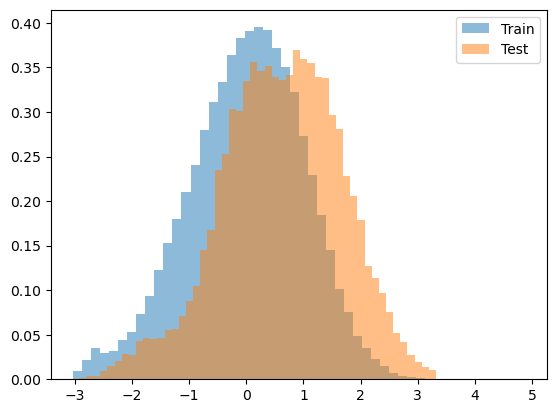

In [ ]:
gem.Y.plot_yields()

In [ ]:
#example of how to unscale a value
gem.Y.scaler.inverse_transform(np.array(1.4).reshape(-1,1))

array([[13.27959341]])

In [ ]:
tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

tr_dl = DataLoader(tr_ds, batch_size=4)
te_dl = DataLoader(te_ds, batch_size=4)
dls = DataLoaders(tr_dl,te_dl)